Name: Aaron Jiang

Project Description:

This notebook aims to analyze the market performance of each brand of sneakers through plots, before constructing a model to predict the last/most recent sale of a sneaker on the marketplace site, StockX.com. The input data shown below was obtained from webscraping the site's Sneakers catalog, from pages 1 through 25. The type of data includes the name of the sneaker, the brand, release date, current asks and bids, number of sales this quarter, annual high/low, volidity, average deadstock (fresh out of box) value, price premium, and change percentage.

As for why I had chosen this topic, I actually attempted to do this project around fall quarter, after taking your CIS 41A course. Looking back at that attempt, I barely got the webscraping to work, and trying to make a meaningful analysis without knowledge of pandas was much more complicated than it needed to be. I had been thinking to reattempt this project with what I know now, which is why I had chosen this topic in specific. I also have sold a handful of products using StockX with some success, but not much.

Background Information:

This dataset was very limited in it's number of brands and other market data, but I used these columns as a template to add onto.
https://www.kaggle.com/datasets/hudsonstuck/stockx-data-contest

This is my scraped data, published on kaggle.

https://www.kaggle.com/datasets/ajiaron/stockx-sneaker-data

Site catalog, from page 1-25. Each row is a tile on the catalog.

https://stockx.com/sneakers?page=1

Import necessary modules

In [72]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
import time
%matplotlib inline
plt.style.use('seaborn-whitegrid')

Read file into dataframe, drop extra index column

In [73]:
df = pd.read_csv('sneakers.csv').drop(columns=['Unnamed: 0'])
print('# of rows:',df.shape[0],'\n# of columns:',df.shape[1])
df.head(5)


# of rows: 1000 
# of columns: 17


,item,brand,retail,release,lowestAsk,numberOfAsks,salesThisPeriod,highestBid,numberOfBids,annualHigh,annualLow,volatility,deadstockSold,pricePremium,averageDeadstockPrice,lastSale,changePercentage
0,Jordan 4 Retro Infrared,Jordan,200,2022-06-15,238,1921,2554,300,1002,2043,216,0.027657,3306,0.285,287,257,0.011811
1,adidas Yeezy Foam RNR Onyx,adidas,80,2022-06-08,153,3827,2338,233,1183,833,136,0.080396,10289,1.375,186,190,0.055556
2,Jordan 1 Retro High OG Visionaire,Jordan,170,2022-06-11,181,1368,420,200,580,343,137,0.049730,1378,0.253,206,213,0.105689
3,NikeCraft General Purpose Shoe Tom Sachs,Nike,110,2022-06-10,259,584,348,775,1136,2199,100,0.248204,836,5.355,552,699,0.035556
4,adidas Yeezy Boost 700 Hi-Res Red,adidas,300,2022-06-17,329,453,198,350,194,484,266,0.114064,218,-0.113,350,266,-0.139159


Check for NaN's and drop sneakers with no release date, since this means the shoe hasn't been released to the public. Print the remaining rows and columns.

In [74]:
df.isna().sum()
df = df.dropna(axis=0)
print('# of rows:',df.shape[0],'\n# of columns:',df.shape[1])

# of rows: 928 
# of columns: 17


Change brand to numeric data, shorten column names. Change release column to datetime to be used for the regression model later. Print first five rows of the dataframe with the new column names.

In [75]:
labels = dict(zip(df.brand.unique(), range(df.brand.nunique())))
df.brand = df.brand.apply(lambda x: labels[x])
df.release = pd.to_datetime(df.release)
df.columns = df.columns.str.replace('(?i)(numberOf|deadstock|percentage|price)', '').str.lower()
df.head()


/var/folders/b2/15kf1gds1n31r7bb_mz7b3km0000gn/T/ipykernel_3755/2864629975.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df.columns = df.columns.str.replace('(?i)(numberOf|deadstock|percentage|price)', '').str.lower()


,item,brand,retail,release,lowestask,asks,salesthisperiod,highestbid,bids,annualhigh,annuallow,volatility,sold,premium,average,lastsale,change
0,Jordan 4 Retro Infrared,0,200,2022-06-15,238,1921,2554,300,1002,2043,216,0.027657,3306,0.285,287,257,0.011811
1,adidas Yeezy Foam RNR Onyx,1,80,2022-06-08,153,3827,2338,233,1183,833,136,0.080396,10289,1.375,186,190,0.055556
2,Jordan 1 Retro High OG Visionaire,0,170,2022-06-11,181,1368,420,200,580,343,137,0.049730,1378,0.253,206,213,0.105689
3,NikeCraft General Purpose Shoe Tom Sachs,2,110,2022-06-10,259,584,348,775,1136,2199,100,0.248204,836,5.355,552,699,0.035556
4,adidas Yeezy Boost 700 Hi-Res Red,1,300,2022-06-17,329,453,198,350,194,484,266,0.114064,218,-0.113,350,266,-0.139159


Print the top four most frequent brands in the dataframe, which will be used later for plotting. Other brands will be used as one category in the plot.

In [76]:
from collections import Counter
temp = df.groupby(['brand']).mean()
rev_labels = {v:k for k,v in labels.items()}
count = Counter(df.brand).most_common(4)
print(pd.Series({rev_labels[k]:v for k,v in dict(count).items()}))


Nike           379
Jordan         330
adidas         122
New Balance     57
dtype: int64


Find the number of sneakers that have been resold for more than their initial retail price, and those that have been resold for less than their initial retail price.

In [77]:
loss = df[df.retail > df.lastsale]
profit = df[df.lastsale > df.retail]
print('Number sold at a loss:', len(loss.values))
print('Number sold for profit:',len(profit.values))

Number sold at a loss: 232
Number sold for profit: 682


Plot the profitable sneakers, comparing their price premium percentage with their initial retail value, grouped by the top four most common brands.

From the scatterplot shown below, the brand with the highest price premiums is unsurprisingly, Jordan. This is to be expected, since the culture of buying and reselling sneakers is based on Jordan brand sneakers. Interestingly however, the three outliers from Jordan are all collaboration sneakers with other fashion brands and music artists. These shoes had a retail price between 150 and 200, but have resold for prices between 3,000 and 6,000 shown below the scatterplot. 

Another interesting observation can be seen with adidas. Many of their lower retail-priced sneakers end up with a higher price premium than brands like Nike and New Balance, in contrast to their high retail-priced sneakers underperforming in their price premiums. 

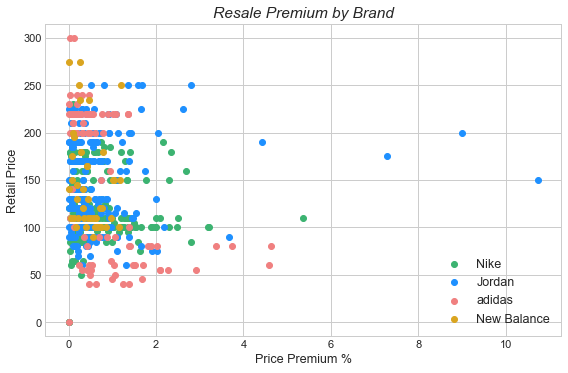

,item,retail,annualhigh,lastsale,premium
478,Jordan 1 Low Fragment x Travis Scott,150,3204,1760,10.731
623,Jordan 4 Retro Off-White Sail (W),200,5999,2000,9.000
919,Jordan 1 Retro High Travis Scott,175,3554,1451,7.291


In [78]:
popular = [i for i in [j[0] for j in count]]
fig, ax = plt.subplots(figsize=(9.25,5.75))
fig.set_facecolor('white')
clrs = ['mediumseagreen', 'dodgerblue', 'lightcoral', 'goldenrod', 'violet']
ax.set_title('Resale Premium by Brand', fontsize=15.5, fontstyle='italic')
for i,j in zip(popular, clrs):
    tag = rev_labels[i]
    ind = profit[profit.brand == i].index
    ax.scatter(df.loc[ind].premium,df.loc[ind].retail,color=j,label=tag)
    ax.set_ylabel('Retail Price', fontsize=12.5)
    ax.set_xlabel('Price Premium %', fontsize=12.5)
plt.legend(loc='lower right', fontsize=12.5)
plt.show()
df[df.premium > 6][['item','retail','annualhigh','lastsale','premium']]

Plot the volatility of all sneakers, grouped by the top four most common brands. 

The plot below shows that adidas has the widest range of price volatility with the greatest number of outliers. This does makes sense when comparing their product line since the ownership of the Yeezy brand to other competitors.

Adidas has been primarily known for their "Ultraboost" shoes, which uses comfort as their selling point with not much of a resale premium and not many models to choose from. In contrast, Yeezy sneakers base their selling point on their celebrity endorsements, with various models from low to very high retail prices. This could explain why the volatility of adidas sneakers tends to be much higher than other brands, since they constantly shift between their comforable and price-stable shoe in the ultraboost with experimental, price-inflated products with Yeezy.

[Text(0.5, 0, '')]

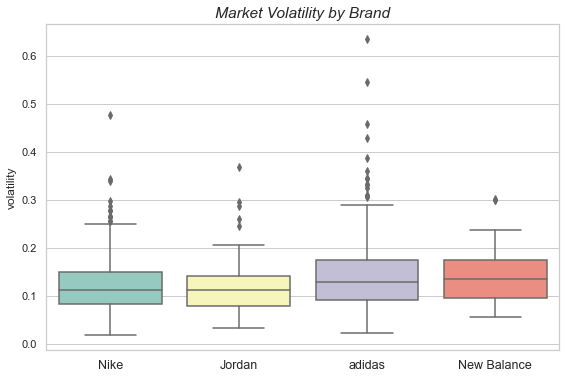

In [79]:
sns.set(rc={'figure.figsize':(9.2,6)})
sns.set_theme(style="whitegrid")
b_idx = df[df.brand.isin(popular)].index
axs = sns.boxplot(x='brand', y='volatility', data=df.loc[b_idx],palette='Set3')
axs.set_xticklabels([rev_labels[i] for i in popular], fontsize=12.5)
axs.set_title('Market Volatility by Brand', fontsize=15.5, fontstyle='italic')
axs.set(xlabel=None)


Create X and y datasets from relevant columns, and change release column to timedelta for training data to be used later. Print the rows and columns from the resulting datasets.

Originally, I wanted to use a model to predict the number of sales in the given quarter/period. Through looking at the data provided by the site catalog, it seems that most of the sneakers do not have sales history for the past quarter, with all of their current sales consisting of the current quarter. This could mean that the majority of the sneakers that have been on the site's last 25 search pages are too new/released too recently to be able to predict how many will be sold in their first quarter.

In [80]:
X = df.drop(columns=['item','lastsale'])
X.release = X.release.astype(np.int64)
y = df.lastsale
print('(X) rows: ' + str(X.shape[0]) + '\ncolumns: ' + str(X.shape[1]))
print('(y) rows: ' + str(len(y)) + '\ncolumns: ' + str(y.ndim))

(X) rows: 928
columns: 15
(y) rows: 928
columns: 1


/var/folders/b2/15kf1gds1n31r7bb_mz7b3km0000gn/T/ipykernel_3755/1205117153.py:2: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  X.release = X.release.astype(np.int64)


Split X and y into training and testing datasets, followed by printing the rows and columns for each.

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25)
print('X training: ' + str(X_train.shape[0]) + ' rows, ' + str(X_train.shape[1]) + ' columns')
print('X testing: ' + str(X_test.shape[0]) + ' rows, ' + str(X_test.shape[1]) + ' columns')
print('y training: ' + str(y_train.shape[0]) + ' rows, ' + str(y_train.ndim) + ' columns')
print('y testing: ' + str(y_test.shape[0]) + ' rows, ' + str(y_test.ndim) + ' columns')


X training: 696 rows, 15 columns
X testing: 232 rows, 15 columns
y training: 696 rows, 1 columns
y testing: 232 rows, 1 columns


For the new feature of the project, I have chosen to compare both the Decision Tree and the Random Forest regression models for prediction of the last sale of a sneaker. I chose to implement the random forest model because the y label (last sale) is dependant on many of the X features, however the X features do not necessarily share a direct relationship with the last sale. For example, the last sale is heavily dependant on the lowest ask and the average deadstock (never worn) price, however the lowest ask and average deadstock price are usually determined by other market conditions, like the number of times the sneaker has been released or the proportion of worn to deadstock pairs available. 

To add a new component to the Decision Tree model, I chose to assign a random split at each node, instead of the default "best" argument given to the model's splitter. I chose to make this adjustment to hopefully get a closer result to the random forest strategy.

After testing observing the accuracy of both models, it is evident that one decision tree is not sufficient to produce an effective output with it's large percentage of error, which makes the random forest model the better option for analyzing the last sale label even with the adjustment.

An interesting observation can be seen in the feature importances for both models. In the random forest model, the lowest ask plays much more of a factor in predicting the item's last sale when compared to the highest bid. This is unexpected, since the two values are expected to be more equal in importance and on average, there are ususally more bidders than askers. While the decision tree gives similar results, it appears that it's importance values vary more heavily when trained, however the lowest ask continues to be the most dominant feature.

In [82]:
from sklearn.tree import DecisionTreeRegressor
regr = DecisionTreeRegressor(splitter='random')
regr.fit(X_train, y_train)
features = pd.DataFrame(regr.feature_importances_, X.columns, columns=['importance'])
print(np.round(features.sort_values(by=['importance'],ascending=False),4))

                 importance
highestbid           0.5409
lowestask            0.2212
average              0.1711
premium              0.0201
change               0.0132
sold                 0.0066
bids                 0.0046
salesthisperiod      0.0046
retail               0.0040
volatility           0.0038
annualhigh           0.0033
asks                 0.0022
annuallow            0.0018
release              0.0014
brand                0.0011


Test and print the accuracy scores of the decision tree regression model, before printing a random sample of 10 predictions. 
Through observation of the RMSE and percent error, it is evident that one decision tree regressor is not the best model to be used in predicting a sneaker's last sale.

In [83]:
y_pred = regr.predict(X_test)
res = pd.DataFrame({'Actual':y_test,'Predicted':y_pred})
RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.round(RMSE,2),'|', f'{RMSE/np.mean(y):.2%}', 'percent error')
print('R^2 Value:', np.round(regr.score(X,y),3))
res.sample(10)

RMSE: 46.94 | 24.22% percent error
R^2 Value: 0.97


,Actual,Predicted
400,281,295.0
828,79,140.0
147,135,157.0
436,385,461.0
347,204,228.0
35,88,151.0
383,185,173.0
96,187,226.0
593,255,270.0
438,166,167.0


Train the random forest regression model with 100 estimators/ trees in the model, and print the feature importances in descending order. Notice that the lowest ask remains as the most important feature, however it's importance is valued much less when compared to the decision tree model.

In [84]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(100)
regr = regr.fit(X_train, y_train)
features = pd.DataFrame(regr.feature_importances_, X.columns, columns=['importance'])
print(np.round(features.sort_values(by=['importance'],ascending=False),4))

                 importance
lowestask            0.4351
average              0.2347
highestbid           0.1459
premium              0.0935
annuallow            0.0319
change               0.0170
annualhigh           0.0082
retail               0.0081
bids                 0.0070
volatility           0.0048
salesthisperiod      0.0041
asks                 0.0037
sold                 0.0034
release              0.0021
brand                0.0005


Print accuracy scores of the random forest model's predictions, with a random sample of 10 predictions. 

Initially, when viewing the model's predictions I was dissapointed in it's accuracy. However after looking at the decision tree regressor's results, it seems that the random forest achieves more accurate predictions on average.

In [85]:
y_pred = regr.predict(X_test)
res = pd.DataFrame({'Actual':y_test,'Predicted':y_pred})
RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.round(RMSE,2),'|', f'{RMSE/np.mean(y):.2%}', 'percent error')
print('R^2 Value:', np.round(regr.score(X,y),3))
res.sample(10)


RMSE: 29.79 | 15.37% percent error
R^2 Value: 0.975


,Actual,Predicted
696,160,165.48
107,208,234.52
445,337,298.17
947,156,154.33
91,269,252.76
703,226,238.28
515,147,156.76
684,319,244.98
436,385,400.01
969,166,170.31


Conclusion

Through the analysis shown of the two plots shown above, it seems that Jordan brand continues to hold their lead in the resale market. While this is not much of a surprise, it should be noted that the majority of their products with high price premiums are collaborations with other designers/companies. 

Although further behind, adidas has an interesting dynamic with their low-retailing sneakers having high premiums, in contrast to their high retailing sneakers bring more price-stable.

While the random forest regression model had not performed as well as I would hoped given it's high percentage of error, I was unsurprised in how difficult the task would be. A piece of data that could have skewed the data would most likely be the fact that the sales history only comes from the most recent items sold on StockX, leaving some sneakers with much more sales and time to gain value than others.

To further this project, I would like to create a visualization similar to the first scatterplot, but with specific models of a given brand. For example, I would like to plot the price premium for Nike "Dunks" vs other models, like the Nike "Air Force 1" and their variations. Through this method, a clearer picture of where brands are succeeding vs where they are not could be made; however, the limited data provided by StockX could cause balancing issues between models. Additionally, I would like to do the same analysis with unprofitable sneakers, however the data would be unbalanced with the rows included here.

As for the regression model, I would like to add additional columns to the X features such as sizing, location of buyers and sellers, and color codes of each sneaker. While this may not have improved the model's accuracy, it would be interesting to see the importance of attributes like color, collaborations, and size on a sneaker's resale value.
